# Correlation between galaxy and DeltaSigma

* Input galaxy files. 
* Input DeltaSigma
* KLLR for smoothing and ridding dependency
* Plotting

## Setup

In [1]:
## testing multidark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import h5py
import tables
import pickle5 as pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import pickle
import os
from glob import glob
import scipy

In [2]:
from timeit import default_timer as timer

In [3]:
ptcl_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p03/'
deltasigma_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/'
clusters_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z1p03/'

##  Import files

In [61]:
halo_file = clusters_dir + 'MDPL2_halos_DS_Ngal_Dgal_lt_2_allM_z1p03.p'
with open(halo_file, 'rb') as handle:
    matched_halo_df = pickle.load(handle)

In [62]:
matched_halo_df.dtypes

scale                 float64
id                     object
pid                     int64
mvir                  float64
rvir                  float64
rs                    float64
Mmvir_all             float64
M200b                 float64
M200c                 float64
M500c                 float64
T/|U|                 float64
Halfmass_Scale        float64
Acc_Rate_Inst         float64
Acc_Rate_100Myr       float64
Acc_Rate_1*Tdyn       float64
Acc_Rate_2*Tdyn       float64
Acc_Rate_Mpeak        float64
Type                    int64
GalaxyIndex             int64
CentralGalaxyIndex      int64
CtreesHaloID            int64
CtreesCentralID         int64
CentralMvir           float64
StellarMass           float64
x                     float64
y                     float64
z                     float64
Ngal                    int64
cluster_id             object
sigma                  object
r_range                object
delta_sigma            object
dtype: object

## Standardized Scales

In [63]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

In [64]:
##mass bins 
mass_bin_edges = [5e13, 1e14, 2e14]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]

## Diagnosis Plots

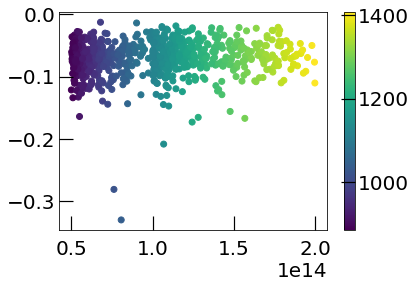

In [65]:
sc = plt.scatter(matched_halo_df.mvir, (matched_halo_df.CentralMvir - matched_halo_df.mvir)/matched_halo_df.mvir, c=matched_halo_df.rvir)
plt.colorbar(sc)

In [66]:
mask = (matched_halo_df.mvir > 2e14) & (matched_halo_df.mvir < 5e14)
cur_df = matched_halo_df[mask]
len(cur_df)

0

## Correlation measurements
* Apply KLLR to reduce scatter and M dependency of the scatter of delta_sigma
* Measure scale dependent correlation of KLLR reduced delta_sigma with N_gal 

Todo:
* Create bootstrap for covariance

In [67]:
import sys
sys.path.append('/global/u1/z/zzhang13')
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *


## Create function to calculate the scatter binned by radius
'''
Calculates the Covariance of the scatter of <f(X,R)> = Y in different radial bins using KLLR. 
---------------------

X: Independent variable array (e.g. Mass)
Y: profile array. Rows are the different halos and columns X-dependent profiles in each radial bins. 
Z: The global quantities (e.g Richness). Len should be number of halos. 
kernel_type: kernel for LLR
kernel_width: width of Gaussian or tophat.
'''
def calc_scatter_cov_radii(x, Y, Z, xrange=None, nbins = 10, kernel_type='gaussian', kernel_width=0.1, nBootstrap=1):     
    output_Data = {}
    
    if len(x.shape) == 1: x = x[:, None] #Make sure X is atleast 2D
    xline = setup_bins(xrange, nbins, x[:, 0])
    cov_bins = np.shape(Y)[1] ## Radial bins
    correlation = np.zeros((nBootstrap, cov_bins))
    covariance = np.zeros((nBootstrap, cov_bins))
    
    #Within each bin apply the KLLR algorithm
    lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
    dz = lm.residuals(x, Z, bins=nbins, nBootstrap = 1,
                fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)
    
    #How to bootstrap resample 
    for i in tqdm(range(nBootstrap)):
        #First "bootstrap" is always using unsampled data
        if i == 0:
            rand_ind = np.ones(Z.size).astype(bool)
        else:
            rand_ind = np.random.randint(0, Z.size, Z.size)

        x_rand = x[rand_ind]
        Z_rand = Z[rand_ind]
        Y_rand = Y[rand_ind, :]
        
        #Bootstrap done outside the function, not inside the function. 
        dz = lm.residuals(x_rand, Z_rand, bins=nbins, nBootstrap = 1,
                fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)
        
        for j in range(cov_bins):
            #Find the data in the i/jth bin
            y_j = Y_rand[:, j]

            #residuals give the scatter normalized by the mean scatter in that bin
            dy_j = lm.residuals(x_rand, y_j, bins=nbins, nBootstrap = 1,
                      fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)

            cov = np.cov(dz, dy_j) #Should consider the weights of the covariance matrix?
            covariance[i,j] = cov[1, 0]
            correlation[i,j] = cov[1, 0]/np.sqrt(cov[0,0] * cov[1,1])            
    
    output_Data['covariance'] = covariance
    output_Data['correlation'] = correlation
    return xline, output_Data

In [68]:
xline, output = calc_scatter_cov_radii(np.log10(np.array(matched_halo_df['mvir'],dtype=float)) , np.vstack(matched_halo_df['delta_sigma']), \
                                       np.array(matched_halo_df['Ngal'],dtype=float), nBootstrap=5)

100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


In [69]:
cov_ds_ngal = output['covariance']
corr_ds_ngal = output['correlation']

cov_mean = np.mean(cov_ds_ngal, axis=0)
cov_err = np.std(cov_ds_ngal, axis=0)
corr_mean = np.mean(corr_ds_ngal, axis=0)
corr_err = np.std(corr_ds_ngal, axis=0)

## Plotting

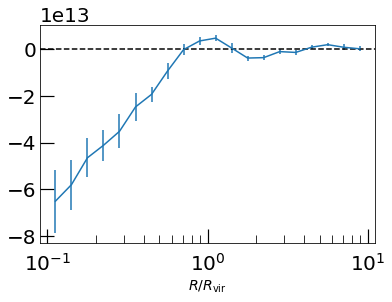

In [70]:
plt.errorbar(r_cent_lin_norm, cov_mean, yerr = cov_err)
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log'); #plt.yscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.show()

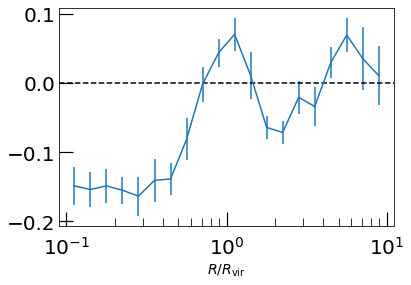

In [71]:
plt.errorbar(r_cent_lin_norm, corr_mean, yerr = corr_err)
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.show()

##### Plotting all mass bins
for cur_bin in iter(mass_bins):
    #Filter current mass bin
    mass_min = cur_bin[0]; mass_max = cur_bin[1]
    filt = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max)
    cur_df = matched_halo_df[filt]

    #Computing the correlation and covariance for individual mass bins
    xline, output = calc_scatter_cov_radii(np.log10(np.array(cur_df['mvir'],dtype=float)) , np.vstack(cur_df['delta_sigma']), np.array(cur_df['Ngal'],dtype=float), nBootstrap=20)
    
    cov_ds_ngal = output['covariance']
    corr_ds_ngal = output['correlation']
    cov_mean = np.mean(cov_ds_ngal, axis=0)
    cov_err = np.std(cov_ds_ngal, axis=0)
    corr_mean = np.mean(corr_ds_ngal, axis=0)
    corr_err = np.std(corr_ds_ngal, axis=0)

    
    plt.errorbar(r_cent_lin_norm, cov_mean, yerr= cov_err, label='[{:.2g}, {:.2g})'.format(mass_min, mass_max))


xline, output_all = calc_scatter_cov_radii(np.log10(np.array(matched_halo_df['mvir'],dtype=float)) , np.vstack(matched_halo_df['delta_sigma']), \
                                       np.array(matched_halo_df['Ngal'],dtype=float), nBootstrap=20)
cov_ds_ngal = output_all['covariance']
corr_ds_ngal = output_all['correlation']
cov_mean = np.mean(cov_ds_ngal, axis=0)
cov_err = np.std(cov_ds_ngal, axis=0)
corr_mean = np.mean(corr_ds_ngal, axis=0)
corr_err = np.std(corr_ds_ngal, axis=0)

plt.errorbar(r_cent_lin_norm, cov_mean, yerr= cov_err, label='All', linewidth=2, alpha=0.3)

plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


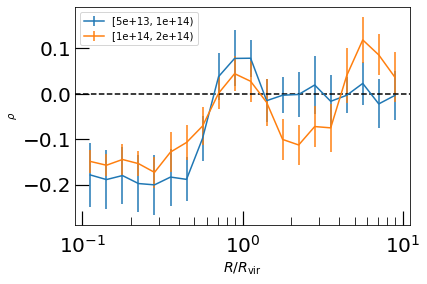

In [72]:
## Plotting all mass bins
for cur_bin in iter(mass_bins):
    #Filter current mass bin
    mass_min = cur_bin[0]; mass_max = cur_bin[1]
    filt = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max)
    cur_df = matched_halo_df[filt]

    #Computing the correlation and covariance for individual mass bins
    xline, output = calc_scatter_cov_radii(np.log10(np.array(cur_df['mvir'],dtype=float)) , np.vstack(cur_df['delta_sigma']), np.array(cur_df['Ngal'],dtype=float), nBootstrap=20)
    
    cov_ds_ngal = output['covariance']
    corr_ds_ngal = output['correlation']
    cov_mean = np.mean(cov_ds_ngal, axis=0)
    cov_err = np.std(cov_ds_ngal, axis=0)
    corr_mean = np.mean(corr_ds_ngal, axis=0)
    corr_err = np.std(corr_ds_ngal, axis=0)

    
    plt.errorbar(r_cent_lin_norm, corr_mean, yerr= corr_err, label='[{:.2g}, {:.2g})'.format(mass_min, mass_max))


xline, output_all = calc_scatter_cov_radii(np.log10(np.array(matched_halo_df['mvir'],dtype=float)) , np.vstack(matched_halo_df['delta_sigma']), \
                                       np.array(matched_halo_df['Ngal'],dtype=float), nBootstrap=20)
cov_ds_ngal = output_all['covariance']
corr_ds_ngal = output_all['correlation']
cov_mean = np.mean(cov_ds_ngal, axis=0)
cov_err = np.std(cov_ds_ngal, axis=0)
corr_mean = np.mean(corr_ds_ngal, axis=0)
corr_err = np.std(corr_ds_ngal, axis=0)

#plt.errorbar(r_cent_lin_norm, corr_mean, yerr= corr_err, label='All', linewidth=5, alpha=1)

plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

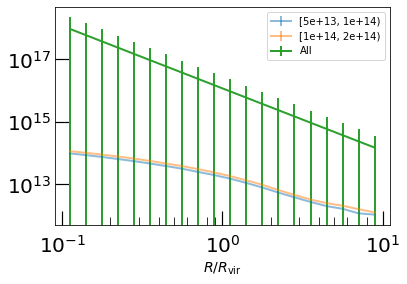

In [56]:
## Plotting all mass bins
for cur_bin in iter(mass_bins):
    #Filter current mass bin
    mass_min = cur_bin[0]; mass_max = cur_bin[1]
    filt = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max)
    cur_df = matched_halo_df[filt]

    #Computing the correlation and covariance for individual mass bins
    DS_cur = np.vstack(cur_df['delta_sigma'])
    
    plt.errorbar(r_cent_lin_norm, np.mean(cur_df['delta_sigma'],axis=0), yerr = np.std(DS_cur,axis=0), label='[{:.2g}, {:.2g})'.format(mass_min, mass_max), linewidth=2, alpha=0.5)

    
DS_all = np.vstack(matched_halo_df['delta_sigma'])
plt.errorbar(r_cent_lin_norm, np.mean(DS_all,axis=0), yerr = np.std(DS_all,axis=0), label='All', linewidth=2, alpha=1)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

## Next steps
* Errors using bootstrap method. 
* Plot separate mass bins
* Combine bins when possible -- use Chi-square test. 


## Testing if you can combine the mass bins. 

## Comparison with theory curves

In [31]:
import camb
from camb import model, initialpower

#Set cosmological parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.77, ombh2=0.022, omch2=0.122)
pars.set_dark_energy(w=-1.0)
pars.InitPower.set_params(ns=0.965)

#This sets the k limits and specifies redshifts
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)

#Linear P(k)
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 1000)

#Note: the above function has the maxkh argument for specifying a different
#kmax than was used above.
#Note: pk has the shape (N_z, N_k)

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
khnl, znl, pknl = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 1000)

Note: redshifts have been re-sorted (earliest first)


In [32]:
import cluster_toolkit

In [33]:
## Universal parameters
radii = np.logspace(-2, 3, 1000) #Mpc/h comoving
R_perp = np.logspace(-2, 2.4, 1000) #Mpc/h comoving; distance on the sky
mass =1e15 #Msun/h
concentration = 7 #arbitrary
Omega_m = 0.307

In [34]:
from cluster_toolkit import xi
import numpy as np

xi_nfw = xi.xi_nfw_at_r(radii, mass, concentration, Omega_m)

In [35]:
from cluster_toolkit import xi
import numpy as np
#Assume that k and P come from somewhere, e.g. CAMB or CLASS
xi_mm = xi.xi_mm_at_r(radii, kh, pk)

In [36]:
from cluster_toolkit import xi
from cluster_toolkit import bias
import numpy as np

#Assume that k and P come from somewhere, e.g. CAMB or CLASS
xi_mm = xi.xi_mm_at_r(radii, kh, pk)
#Assume that k and P_linear came from somewhere, e.g. CAMB or CLASS
bias = bias.bias_at_M(mass, kh, pk, Omega_m)
xi_2halo = xi.xi_2halo(bias, xi_mm)

In [37]:
from cluster_toolkit import xi
#Calculate 1-halo and 2-halo terms here
xi_hm = xi.xi_hm(xi_nfw, xi_2halo)

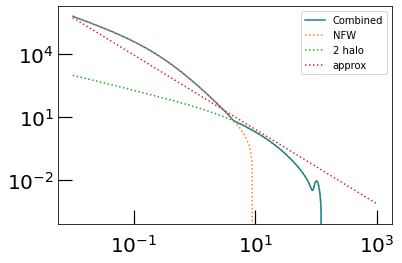

In [38]:
xi_approx_2halo = 10*(radii/4.7)**(-1.77)

plt.plot(radii, xi_hm, label='Combined')
plt.plot(radii, xi_nfw, label='NFW', linestyle='dotted')
plt.plot(radii, xi_2halo, label='2 halo', linestyle='dotted')
plt.plot(radii, xi_approx_2halo, label = 'approx', linestyle='dotted')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [39]:
from cluster_toolkit import deltasigma

#Assume that radii and xi_hm are computed here
Sigma = deltasigma.Sigma_at_R(R_perp, radii, xi_hm, mass, concentration, Omega_m)

In [40]:
from cluster_toolkit import deltasigma
Sigma_nfw = deltasigma.Sigma_nfw_at_R(R_perp, mass, concentration, Omega_m)

In [41]:
from cluster_toolkit import deltasigma

DeltaSigma = deltasigma.DeltaSigma_at_R(R_perp, R_perp, Sigma, mass, concentration, Omega_m)

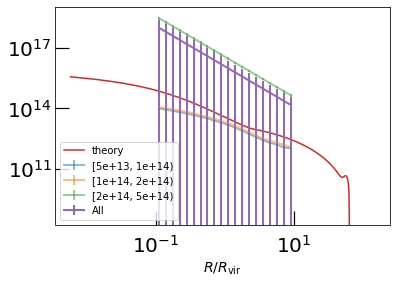

In [42]:
## Plotting all mass bins
for cur_bin in iter(mass_bins):
    #Filter current mass bin
    mass_min = cur_bin[0]; mass_max = cur_bin[1]
    filt = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max)
    cur_df = matched_halo_df[filt]

    #Computing the correlation and covariance for individual mass bins
    DS_cur = np.vstack(cur_df['delta_sigma'])
    
    plt.errorbar(r_cent_lin_norm, np.mean(cur_df['delta_sigma'],axis=0), yerr = np.std(DS_cur,axis=0), label='[{:.2g}, {:.2g})'.format(mass_min, mass_max), linewidth=2, alpha=0.5)
    
plt.plot(R_perp/1.7, Sigma*1e12 , label='theory')
DS_all = np.vstack(matched_halo_df['delta_sigma'])
plt.errorbar(r_cent_lin_norm, np.mean(DS_all,axis=0), yerr = np.std(DS_all,axis=0), label='All', linewidth=2, alpha=1)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

In [43]:
## Compute average density
V = 1000**3 ##Mpc
M = 1.51e9 *3840**3
rho = M/V
rho_2D_200dz = rho * 2* 200
print('{:.2g} M_sun/Mpc^3'.format(rho))
print('{:.2g} M_sun/Mpc^3'.format(rho_2D_200dz))

8.6e+10 M_sun/Mpc^3
3.4e+13 M_sun/Mpc^3


In [44]:
np.std(DS_all,axis=0)/np.mean(DS_all,axis=0)

array([1.43746833, 1.43740152, 1.43731271, 1.43719484, 1.43703839,
       1.43684296, 1.43659719, 1.43627831, 1.43592499, 1.43550161,
       1.43505894, 1.43462844, 1.43423827, 1.43395189, 1.43352721,
       1.43301462, 1.43211294, 1.43046646, 1.4292292 , 1.42638274])

## Debugging the code
* h-scalling. 

In [30]:
from cluster_toolkit import concentration as conc
M = 1e14 #Msun/h
Omega_m = 0.3 #Matter fraction
Omega_b = 0.05 #Baryon fraction
ns = 0.96 #Power spectrum index
h = 0.67 #Hubble constant
#Assume that k and P come from somewhere, e.g. CAMB or CLASS
#k are wavenumbers in h/Mpc and P is the linear power spectrum
#in (Mpc/h)^3
#The Mass_type argument can either be 'mean' or 'crit'
Mass_type = 'mean'
c = conc.concentration_at_M(M, kh, pk, ns, Omega_b, Omega_m, h)

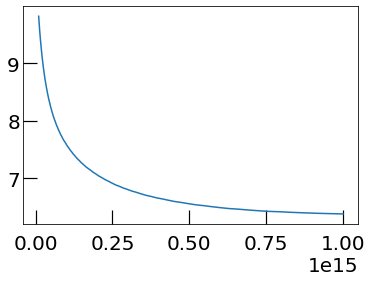

In [376]:
M_arr = np.logspace(13,15,100)
c_arr = np.zeros_like(M_arr)
for i, M in enumerate(M_arr):
    c = conc.concentration_at_M(M, kh, pk, ns, Omega_b, Omega_m, h, Mass_type='mean')
    c_arr[i] = c
plt.plot(M_arr, c_arr)
plt.show()

In [435]:
a =((matched_halo_df['delta_sigma'] + matched_halo_df['sigma']) * ((7.84/10)**2) - matched_halo_df['sigma'])/matched_halo_df['delta_sigma']

In [436]:
np.logspace(-1,1,20)

array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])

In [437]:
a[0]

array([ 0.2900169 ,  0.26723643,  0.27101846,  0.25380859,  0.2401168 ,
        0.32382539,  0.38091202,  0.42646312,  0.42888022,  0.45180716,
        0.45536638,  0.37610746,  0.34857351,  0.21236647,  0.02016275,
       -0.17171243, -0.06284387, -0.09711459, -0.18527263, -0.0220544 ])